## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import pathlib
data_dir = pathlib.Path("/content/drive/My Drive/AI/Upgrad/NLP_CaseStudy2")

## Importing the necessary libraries

In [4]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [5]:
datafile = pathlib.Path("/content/drive/My Drive/AI/Upgrad/NLP_CaseStudy2/complaints-2021-05-14_08_16.json")
with open(datafile, 'r') as f:
    data = json.load(f)

# Opening JSON file
f = pathlib.Path("/content/drive/My Drive/AI/Upgrad/NLP_CaseStudy2/complaints-2021-05-14_08_16.json")

# returns JSON object as
# a dictionary
# data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

# Inspect the dataframe to understand the given data.

In [6]:
df.shape

(78313, 22)

In [7]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [9]:
#Assign new column names
df.columns=[col.replace('_source.','') for col in df.columns]

In [10]:
df = df.rename(columns={'_index': 'index','_type': 'type','_score': 'score','complaint_what_happened':'complaints'})

In [11]:
#Assign nan in place of blanks in the complaints column
df['complaints']=df['complaints'].replace('', np.nan)

In [12]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaints'],inplace=True)

In [13]:
df[df['complaints'].str.contains('\!')].shape

(2372, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [14]:
# Write your function here to clean the text and remove all the unnecessary elements.
df['complaints'] = df['complaints'].str.lower()

In [15]:
df2 = df.copy()
# df = df2.copy()

In [16]:
#removing \n
df['complaints'] = df['complaints'].str.replace('\n', ' ', n=-1)

In [17]:
#Remove text in square brackets
df['complaints'] = df['complaints'].str.replace('\[.*\]', '', regex=True, n=-1)

In [18]:
#remove puncuations
df['complaints'] = df['complaints'].str.replace('[^\w\s\d]', '', regex=True, n=-1)

In [19]:
#remove words contaning numbers
df['complaints'] = df['complaints'].str.replace('\b\w*\d+\w*\b', '', regex=True, n=-1)

In [20]:
df['complaints'] = df['complaints'].str.replace(' \d+ ', ' ', regex=True, n=-1)

In [21]:
#removing XXXX
df['complaints'] = df['complaints'].str.replace('x{2,}', '', regex=True, n=-1)

In [22]:
#removing multiple spaces with single space
df['complaints'] = df['complaints'].str.replace(' {2,}', ' ', regex=True, n=-1)

In [23]:
df['complaints'].iloc[0]

'good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help'

In [24]:
#Write your function to Lemmatize the texts
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm")
nlp.tokenizer = Tokenizer(nlp.vocab)

def lemmatize_sentence(text):
    doc = nlp(text)
    lemmatized_sentence = " ".join([token.lemma_ for token in doc])
    return lemmatized_sentence

df['lemmatized complaints'] = df['complaints'].apply(lemmatize_sentence)

In [25]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean=df[['complaints','lemmatized complaints']]

In [26]:
df_clean.head()

,complaints,lemmatized complaints
1,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...
2,i upgraded my card in 2018 and was told by the...,I upgrade my card in 2018 and be tell by the a...
10,chase card was reported on 2019 however fraudu...,chase card be report on 2019 however fraudulen...
11,on 2018 while trying to book a ticket i came a...,on 2018 while try to book a ticket I come acro...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...


In [27]:
#Write your function to extract the POS tags

def pos_tag(text):
    doc = nlp(text)
    pos_tags = " ".join([token.tag_ for token in doc])
    return pos_tags

df_clean['POS tags'] = df_clean['lemmatized complaints'].apply(pos_tag)
# df_clean["complaint_POS_removed"] =  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


<ipython-input-27-5958b5284f6d>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
def only_nn(row):
    res = ""
    lemmas = row['lemmatized complaints'].split()
    tags = row['POS tags'].split()
    for i in range(len(lemmas)):
        if tags[i] == 'NN':
            res += lemmas[i] + " "
    return res[:-1]

df_clean["complaint_POS_removed"] =  df_clean.apply(only_nn,axis=1)


<ipython-input-31-867b48f0ae21>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized complaints,POS tags,complaint_POS_removed
1,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,JJ NN PRP$ NN VB CC PRP VBP PRP IN PRP MD VB P...,morning name stop bank cardmember service ask ...
2,i upgraded my card in 2018 and was told by the...,I upgrade my card in 2018 and be tell by the a...,PRP VBP PRP$ NN IN CD CC VB VBN IN DT NN WP VB...,card agent anniversary date agent information ...
10,chase card was reported on 2019 however fraudu...,chase card be report on 2019 however fraudulen...,NN NN VB NN IN CD RB JJ NN VBP VB VB PRP$ NN I...,chase card report application identity consent...
11,on 2018 while trying to book a ticket i came a...,on 2018 while try to book a ticket I come acro...,IN CD IN VB TO VB DT NN PRP VBP IN DT NN IN TO...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,PRP$ JJ NN VB PRP VBP IN PRP VBP PRP IN PRP$ N...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,IN VB DT NN NN NN IN RB IN DT NN VB VB JJ NN I...,chase card customer decade solicitation credit...
78309,on wednesday i called chas my visa credit card...,on wednesday I call chas my visa credit card p...,IN NNP PRP VBP VBZ PRP$ NN NN NN NN CC VB WRB ...,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not underst...,I be not familiar with pay and do not understa...,PRP VBP RB JJ IN NN CC VBP RB VB DT JJ NN DT V...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs ive had cha...,I have have flawless credit for yrs ive have c...,PRP VBP VB JJ NN IN NNP NNP VBP NN NN NN NN NN...,credit chase credit card chase freedom problem...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




<ipython-input-36-70d641d3c336>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



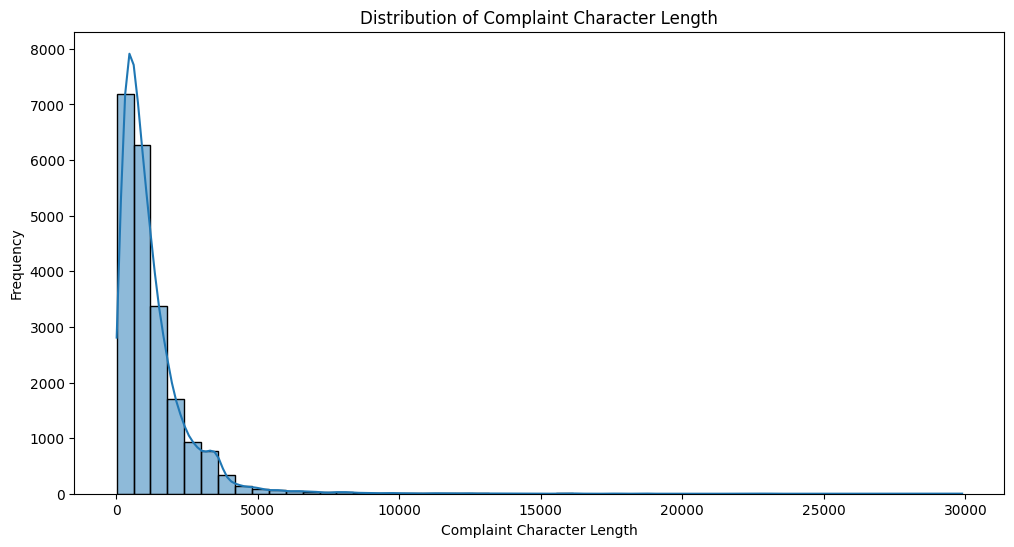

In [36]:
# Write your code here to visualise the data according to the 'Complaint' character length

df_clean['Complaint_length'] = df_clean['complaints'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(df_clean['Complaint_length'], bins=50, kde=True)
plt.title('Distribution of Complaint Character Length')
plt.xlabel('Complaint Character Length')
plt.ylabel('Frequency')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [40]:
# #Using a word cloud find the top 40 words by frequency among all the articles after processing the text
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

# Combine all complaints into a single string
all_complaints = ' '.join(df_clean['complaint_POS_removed'].astype(str).tolist())

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      stopwords=STOPWORDS,
                      max_words=40,
                      contour_width=3,
                      contour_color='steelblue')

# Generate the word cloud
wordcloud.generate(all_complaints)

# Access word frequencies
frequencies = wordcloud.words_

# Print word frequencies
for word, frequency in frequencies.items():
    print(f"{word}: {frequency}")





credit card: 1.0
chase: 0.877893378498266
time: 0.6817485281071054
bank: 0.5206065005242358
information: 0.41075893217194936
day: 0.35277038470844424
issue: 0.3182514718928946
state: 0.30720219372530044
credit report: 0.30405677877248166
month: 0.28841035567384465
company: 0.26332768771675136
account chase: 0.24510041132349383
customer service: 0.2405839180579079
year: 0.23251875151221874
chase credit: 0.2250181466247278
money: 0.2191305750463747
request: 0.21751754173723686
fee: 0.21493668844261635
week: 0.21316235180256474
nothing: 0.21130736349705623
chase account: 0.21082345350431486
way: 0.20251633196225502
transaction: 0.19856440035486733
letter: 0.1968707153802726
claim: 0.19501572707476408
reason: 0.19412855875473828
case: 0.19412855875473828
bank account: 0.1903379304782644
document: 0.18969271715460925
point: 0.18953141382369545
someone: 0.186144043874506
fact: 0.18388579724171303
anything: 0.1834018872489717
account account: 0.18162755060892008
amount: 0.1813855956125494
per

In [41]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

<ipython-input-41-2ee47e6ecbae>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
df_clean.to_excel('df_clean.xlsx')

In [77]:
df_clean2 = pd.read_excel('df_clean.xlsx')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [61]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
all_complaints = ' '.join(df_clean['complaint_POS_removed'].astype(str).tolist())

In [62]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
from nltk import word_tokenize, ngrams
from collections import Counter

tokens = word_tokenize(all_complaints)
unigrams = Counter(ngrams(tokens, 1))

for unigram, frequency in unigrams.most_common(30):
    print(f"{unigram}: {frequency}")


('chase',): 52375
('account',): 46042
('credit',): 31979
('card',): 29804
('bank',): 21115
('payment',): 20330
('time',): 15344
('charge',): 13751
('day',): 12501
('check',): 11835
('money',): 11592
('loan',): 10462
('letter',): 9231
('information',): 9132
('fee',): 8703
('report',): 8673
('call',): 8564
('number',): 8477
('transaction',): 8218
('month',): 8202
('amount',): 8038
('year',): 7944
('customer',): 7862
('mortgage',): 7743
('service',): 7554
('balance',): 7506
('company',): 7377
('phone',): 7310
('claim',): 7126
('state',): 7055


In [68]:
#Print the top 10 words in the unigram frequency
for unigram in unigrams.most_common(10):
    print(f"{unigram}")

(('chase',), 52375)
(('account',), 46042)
(('credit',), 31979)
(('card',), 29804)
(('bank',), 21115)
(('payment',), 20330)
(('time',), 15344)
(('charge',), 13751)
(('day',), 12501)
(('check',), 11835)


In [70]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
bigrams = Counter(ngrams(tokens, 2))

for bigram, frequency in bigrams.most_common(30):
    print(f"{bigram}: {frequency}")


('credit', 'card'): 12399
('credit', 'report'): 3770
('account', 'chase'): 3039
('customer', 'service'): 2983
('chase', 'credit'): 2790
('chase', 'account'): 2614
('bank', 'account'): 2360
('account', 'account'): 2252
('check', 'account'): 2235
('chase', 'bank'): 2229
('debit', 'card'): 1960
('checking', 'account'): 1918
('chase', 'card'): 1774
('credit', 'score'): 1626
('card', 'account'): 1619
('phone', 'call'): 1588
('card', 'chase'): 1577
('account', 'credit'): 1483
('payment', 'payment'): 1335
('account', 'bank'): 1287
('money', 'account'): 1278
('interest', 'rate'): 1251
('business', 'day'): 1208
('phone', 'number'): 1196
('account', 'number'): 1143
('card', 'company'): 1113
('charge', 'account'): 1041
('chase', 'chase'): 1035
('card', 'credit'): 1010
('card', 'card'): 1006


In [71]:
#Print the top 10 words in the bigram frequency
for bigram, frequency in bigrams.most_common(10):
    print(f"{bigram}: {frequency}")

('credit', 'card'): 12399
('credit', 'report'): 3770
('account', 'chase'): 3039
('customer', 'service'): 2983
('chase', 'credit'): 2790
('chase', 'account'): 2614
('bank', 'account'): 2360
('account', 'account'): 2252
('check', 'account'): 2235
('chase', 'bank'): 2229


In [73]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
trigrams = Counter(ngrams(tokens, 3))

for trigram, frequency in trigrams.most_common(30):
    print(f"{trigram}: {frequency}")


('chase', 'credit', 'card'): 1865
('credit', 'card', 'account'): 1051
('credit', 'card', 'company'): 944
('credit', 'card', 'chase'): 716
('inquiry', 'credit', 'report'): 498
('credit', 'card', 'credit'): 495
('account', 'credit', 'card'): 466
('card', 'credit', 'card'): 395
('chase', 'customer', 'service'): 381
('charge', 'credit', 'card'): 377
('chase', 'checking', 'account'): 365
('credit', 'report', 'credit'): 360
('customer', 'service', 'representative'): 328
('credit', 'reporting', 'agency'): 322
('chase', 'bank', 'account'): 297
('credit', 'card', 'payment'): 292
('account', 'chase', 'account'): 285
('credit', 'card', 'charge'): 275
('account', 'credit', 'report'): 275
('bank', 'credit', 'card'): 269
('credit', 'reporting', 'act'): 262
('chase', 'auto', 'finance'): 258
('credit', 'card', 'balance'): 256
('chase', 'card', 'service'): 254
('credit', 'card', 'card'): 243
('payment', 'credit', 'card'): 239
('victim', 'identity', 'theft'): 238
('credit', 'report', 'chase'): 235
('fre

In [74]:
#Print the top 10 words in the trigram frequency
for trigram, frequency in trigrams.most_common(10):
    print(f"{trigram}: {frequency}")

('chase', 'credit', 'card'): 1865
('credit', 'card', 'account'): 1051
('credit', 'card', 'company'): 944
('credit', 'card', 'chase'): 716
('inquiry', 'credit', 'report'): 498
('credit', 'card', 'credit'): 495
('account', 'credit', 'card'): 466
('card', 'credit', 'card'): 395
('chase', 'customer', 'service'): 381
('charge', 'credit', 'card'): 377


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [75]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

<ipython-input-75-d4beb8194a2f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [76]:
#All masked texts has been removed
df_clean

,complaints,lemmatized complaints,POS tags,complaint_POS_removed,Complaint_length,Complaint_clean
1,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,JJ NN PRP$ NN VB CC PRP VBP PRP IN PRP MD VB P...,morning name stop bank cardmember service ask ...,439,morning name stop bank cardmember service ask ...
2,i upgraded my card in 2018 and was told by the...,I upgrade my card in 2018 and be tell by the a...,PRP VBP PRP$ NN IN CD CC VB VBN IN DT NN WP VB...,card agent anniversary date agent information ...,301,card agent anniversary date agent information ...
10,chase card was reported on 2019 however fraudu...,chase card be report on 2019 however fraudulen...,NN NN VB NN IN CD RB JJ NN VBP VB VB PRP$ NN I...,chase card report application identity consent...,214,chase card report application identity consent...
11,on 2018 while trying to book a ticket i came a...,on 2018 while try to book a ticket I come acro...,IN CD IN VB TO VB DT NN PRP VBP IN DT NN IN TO...,ticket offer ticket reward card information of...,1436,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,PRP$ JJ NN VB PRP VBP IN PRP VBP PRP IN PRP$ N...,son chase account fund chase bank account mone...,447,son chase account fund chase bank account mone...
...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,IN VB DT NN NN NN IN RB IN DT NN VB VB JJ NN I...,chase card customer decade solicitation credit...,638,chase card customer decade solicitation credit...
78309,on wednesday i called chas my visa credit card...,on wednesday I call chas my visa credit card p...,IN NNP PRP VBP VBZ PRP$ NN NN NN NN CC VB WRB ...,visa credit card provider claim purchase prote...,2012,visa credit card provider claim purchase prote...
78310,i am not familiar with pay and did not underst...,I be not familiar with pay and do not understa...,PRP VBP RB JJ IN NN CC VBP RB VB DT JJ NN DT V...,pay risk consumer chase bank app chase year ba...,2254,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs ive had cha...,I have have flawless credit for yrs ive have c...,PRP VBP VB JJ NN IN NNP NNP VBP NN NN NN NN NN...,credit chase credit card chase freedom problem...,1922,credit chase credit card chase freedom problem...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [78]:
#Write your code here to initialise the TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [81]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [80]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [82]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [91]:
W = nmf_model.fit_transform(dtm)

In [92]:
W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(num_topics)])

In [100]:
W

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,0.021831,0.002256,0.016035,0.013900,0.010630
1,0.007831,0.015724,0.003187,0.001364,0.006718
2,0.000000,0.034693,0.000000,0.049327,0.002471
3,0.017594,0.033028,0.005372,0.051263,0.006902
4,0.071452,0.000554,0.008030,0.000000,0.011173
...,...,...,...,...,...
21067,0.000000,0.089252,0.010448,0.000000,0.028395
21068,0.005745,0.013674,0.003899,0.003827,0.039805
21069,0.014328,0.000561,0.006203,0.026788,0.028269
21070,0.000000,0.079085,0.070339,0.000000,0.000000


In [85]:
feature_names = tfidf.get_feature_names_out()
len(feature_names)

7023

In [86]:
#Print the Top15 words for each of the topics
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-16:-1]]))
    print("\n")

Topic #1:
account check bank money fund chase deposit branch day checking number business transfer transaction customer


Topic #2:
card credit chase balance account limit score year point offer month purchase application service reason


Topic #3:
payment loan mortgage chase home month modification time year rate balance property statement date day


Topic #4:
report inquiry credit company information reporting account debt identity theft score letter date file bureaus


Topic #5:
charge dispute chase transaction fee claim merchant fraud purchase service email refund time company day




In [108]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
W['best_topic'] = W.apply(lambda x: x.argmax(), axis=1)

In [109]:
W

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,best_topic
0,0.021831,0.002256,0.016035,0.013900,0.010630,0
1,0.007831,0.015724,0.003187,0.001364,0.006718,1
2,0.000000,0.034693,0.000000,0.049327,0.002471,3
3,0.017594,0.033028,0.005372,0.051263,0.006902,3
4,0.071452,0.000554,0.008030,0.000000,0.011173,0
...,...,...,...,...,...,...
21067,0.000000,0.089252,0.010448,0.000000,0.028395,1
21068,0.005745,0.013674,0.003899,0.003827,0.039805,4
21069,0.014328,0.000561,0.006203,0.026788,0.028269,4
21070,0.000000,0.079085,0.070339,0.000000,0.000000,1


In [125]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean = df_clean.reset_index(drop=True)
df_clean['Topic'] = W['best_topic']

In [126]:
df_clean.head()

,complaints,lemmatized complaints,POS tags,complaint_POS_removed,Complaint_length,Complaint_clean,Topic
0,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,JJ NN PRP$ NN VB CC PRP VBP PRP IN PRP MD VB P...,morning name stop bank cardmember service ask ...,439,morning name stop bank cardmember service ask ...,0
1,i upgraded my card in 2018 and was told by the...,I upgrade my card in 2018 and be tell by the a...,PRP VBP PRP$ NN IN CD CC VB VBN IN DT NN WP VB...,card agent anniversary date agent information ...,301,card agent anniversary date agent information ...,1
2,chase card was reported on 2019 however fraudu...,chase card be report on 2019 however fraudulen...,NN NN VB NN IN CD RB JJ NN VBP VB VB PRP$ NN I...,chase card report application identity consent...,214,chase card report application identity consent...,3
3,on 2018 while trying to book a ticket i came a...,on 2018 while try to book a ticket I come acro...,IN CD IN VB TO VB DT NN PRP VBP IN DT NN IN TO...,ticket offer ticket reward card information of...,1436,ticket offer ticket reward card information of...,3
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,PRP$ JJ NN VB PRP VBP IN PRP VBP PRP IN PRP$ N...,son chase account fund chase bank account mone...,447,son chase account fund chase bank account mone...,0


In [128]:
df_clean2 = df_clean.copy()

In [129]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaints,lemmatized complaints,POS tags,complaint_POS_removed,Complaint_length,Complaint_clean,Topic
0,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,JJ NN PRP$ NN VB CC PRP VBP PRP IN PRP MD VB P...,morning name stop bank cardmember service ask ...,439,morning name stop bank cardmember service ask ...,0
10,mishandling of this account by chase auto and,mishandle of this account by chase auto and,NN IN DT NN IN NN NN CC,mishandle account chase auto,46,mishandle account chase auto,0
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,IN RP NN NNP NNP NNP VB PRP$ NN IN PRP$ NN NN ...,notice account debit card branch customer serv...,2227,notice account debit card branch customer serv...,0
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,PRP$ JJ NN VB PRP VBP IN PRP VBP PRP IN PRP$ N...,son chase account fund chase bank account mone...,447,son chase account fund chase bank account mone...,0
12,i opened an account with chase bank on and use...,I open an account with chase bank on and use a...,PRP VBP DT NN IN NNP NNP RP CC VB DT NN IN NN ...,account code bonus term everything account dep...,372,account code bonus term everything account dep...,0
14,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,PRP$ NN NNP NN VB NN IN DT NN NN PRP VBP NN IN...,chase card decline catering order place brothe...,1847,chase card decline catering order place brothe...,1
25,i currently have over chase ultimate rewards p...,I currently have over chase ultimate reward po...,PRP RB VBP IN VB JJ NN NN WDT VBP JJ IN JJS IN...,reward point month reward account bonus chase ...,1734,reward point month reward account bonus chase ...,1
22,my roommate was stealing my chase debit card a...,my roommate be steal my chase debit card and d...,PRP$ NN VB VB PRP$ NN NN NN CC NN NN VBP TO VB...,roommate chase debit card driver license money...,676,roommate chase debit card driver license money...,1
1,i upgraded my card in 2018 and was told by the...,I upgrade my card in 2018 and be tell by the a...,PRP VBP PRP$ NN IN CD CC VB VBN IN DT NN WP VB...,card agent anniversary date agent information ...,301,card agent anniversary date agent information ...,1
21,i am a senior citizen that has been scammed by...,I be a senior citizen that have be scamme by s...,PRP VBP DT JJ NN WDT VBP VBN NNS IN JJ NN IN I...,citizen company time share company nothing ref...,323,citizen company time share company nothing ref...,1


In [130]:
df_clean.shape

(25, 7)

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [138]:
df_clean = df_clean2.copy()

In [140]:
df_clean['Topic'].value_counts()

,count
Topic,
0,5131
2,5058
4,4498
1,4042
3,2343


In [141]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Mortgage/Loan',
    3: 'Theft/Dispute Reporting',
    4: 'Others'
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [142]:
df_clean

,complaints,lemmatized complaints,POS tags,complaint_POS_removed,Complaint_length,Complaint_clean,Topic
0,good morning my name is and i appreciate it if...,good morning my name be and I appreciate it if...,JJ NN PRP$ NN VB CC PRP VBP PRP IN PRP MD VB P...,morning name stop bank cardmember service ask ...,439,morning name stop bank cardmember service ask ...,Bank Account services
1,i upgraded my card in 2018 and was told by the...,I upgrade my card in 2018 and be tell by the a...,PRP VBP PRP$ NN IN CD CC VB VBN IN DT NN WP VB...,card agent anniversary date agent information ...,301,card agent anniversary date agent information ...,Credit card or prepaid card
2,chase card was reported on 2019 however fraudu...,chase card be report on 2019 however fraudulen...,NN NN VB NN IN CD RB JJ NN VBP VB VB PRP$ NN I...,chase card report application identity consent...,214,chase card report application identity consent...,Theft/Dispute Reporting
3,on 2018 while trying to book a ticket i came a...,on 2018 while try to book a ticket I come acro...,IN CD IN VB TO VB DT NN PRP VBP IN DT NN IN TO...,ticket offer ticket reward card information of...,1436,ticket offer ticket reward card information of...,Theft/Dispute Reporting
4,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,PRP$ JJ NN VB PRP VBP IN PRP VBP PRP IN PRP$ N...,son chase account fund chase bank account mone...,447,son chase account fund chase bank account mone...,Bank Account services
...,...,...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,IN VB DT NN NN NN IN RB IN DT NN VB VB JJ NN I...,chase card customer decade solicitation credit...,638,chase card customer decade solicitation credit...,Credit card or prepaid card
21068,on wednesday i called chas my visa credit card...,on wednesday I call chas my visa credit card p...,IN NNP PRP VBP VBZ PRP$ NN NN NN NN CC VB WRB ...,visa credit card provider claim purchase prote...,2012,visa credit card provider claim purchase prote...,Others
21069,i am not familiar with pay and did not underst...,I be not familiar with pay and do not understa...,PRP VBP RB JJ IN NN CC VBP RB VB DT JJ NN DT V...,pay risk consumer chase bank app chase year ba...,2254,pay risk consumer chase bank app chase year ba...,Others
21070,i have had flawless credit for yrs ive had cha...,I have have flawless credit for yrs ive have c...,PRP VBP VB JJ NN IN NNP NNP VBP NN NN NN NN NN...,credit chase credit card chase freedom problem...,1922,credit chase credit card chase freedom problem...,Credit card or prepaid card


In [143]:
df_clean.to_excel('df_clean.xlsx')

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



